# Initializing

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import comet_ml
import os
import torch
from torch.utils.data import DataLoader
from pathlib import Path

from src.utils.coco import COCODataset
from src.utils.pretty_print import *
from src.models import get_model_resnet34
from src.utils.train import resnet_training_testing_loop
from src.utils.comet import CometLogger
from dotenv import load_dotenv

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = "cuda" if torch.cuda.is_available() else "cpu"

SEED = 42

# for reproducibility
torch.manual_seed(SEED)

# Datasets

## COCO Datasets

In [16]:
tile_path = Path("/storage01/bolma/dev/data/datasets/WSI-ROI/tiles/l6_256x256_tiles.json")

In [17]:
import albumentations as A

transform = A.Compose([
    #A.HorizontalFlip(0.5),
    #A.VerticalFlip(0.5),
    A.ToTensorV2(),
])


In [18]:
train_dataset = COCODataset(
    annotation_file=tile_path,
    train=True,
    transform=None,
    random_seed=SEED,
    split_file=Path("dataset_split.json"),
    bbox_format='pascal_voc'
)

test_dataset = COCODataset(
    annotation_file=tile_path,
    train=False,
    transform=None,
    random_seed=SEED,
    split_file=Path("dataset_split.json"),
    bbox_format='pascal_voc'
)

# Checks
train_images = set(id for id in train_dataset.image_ids)
test_images = set(id for id in test_dataset.image_ids)

print(f"Training image id-s: \t{train_images}")
print(f"\nTest image id-s: \t{test_images}")

# Overlapping images between datasets
overlapping_images = train_images.intersection(test_images)

if overlapping_images:
    print("\n[WARNING]: Overlapping images found:")
    for img in overlapping_images:
        print(f"- {img}")
else:
    print_success("Datasets are properly split and ready to use!")



loading annotations into memory...
Done (t=0.01s)
creating index...
index created!

✅ Loaded split from dataset_split.json

✅ Found 4423 training images and 1211 test images

✅ Loaded training set with 4423 images

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!

✅ Loaded split from dataset_split.json

✅ Found 4423 training images and 1211 test images

✅ Loaded test set with 1211 images

Training image id-s: 	{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 1

### Visualization

Training Dataset Examples:
Image index: 403 (Image ID: 403)


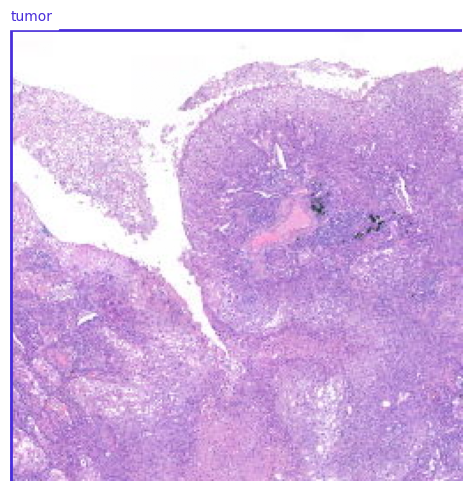

Image index: 4202 (Image ID: 5282)


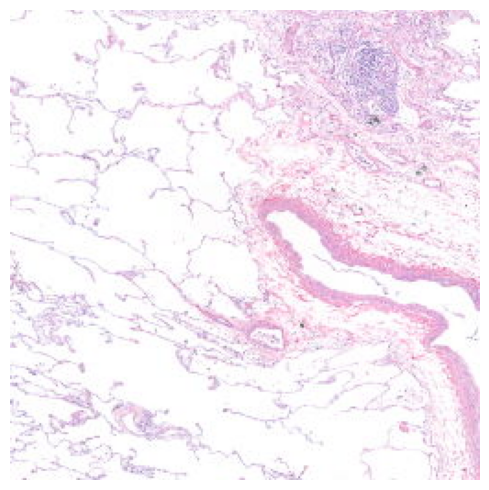

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
from matplotlib.patches import Rectangle

def visualize_coco_samples(dataset, num_samples=3, indices=None, figsize=(15, 5), 
                          show_masks=True, show_boxes=True, show_labels=True,
                          mask_alpha=0.3, random_color=True):
    """
    Visualizes samples from COCO dataset with annotations.
    """
    if indices is None:
        # Get random indices
        indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    for idx in indices:
        print(f"Image index: {idx} (Image ID: {dataset.image_ids[idx]})")
        image, target = dataset[idx]
        
        # If image is a tensor, convert to numpy array for visualization
        if isinstance(image, torch.Tensor):
            img = image.cpu().numpy().transpose(1, 2, 0)
            # Use consistent scaling - divide by 255 instead of min-max normalization
            img = img / 255.0
            # Clip to valid range
            img = np.clip(img, 0, 1)
        else:
            img = np.array(image) / 255.0
        
        # Create figure and axes
        fig, ax = plt.subplots(figsize=figsize)
        
        # Display image
        ax.imshow(img)
        
        # Get masks, boxes, and labels from target
        masks = target['masks']
        boxes = target['boxes']
        labels = target['labels']
        
        # Create a single combined overlay for all masks
        if show_masks and len(masks) > 0:
            # Initialize combined overlay
            h, w = masks[0].shape if len(masks) > 0 else img.shape[:2]
            combined_overlay = np.zeros((h, w, 4))  # RGBA image for overlay
            
            for i in range(len(masks)):
                if i < len(masks):
                    # Generate color for this instance
                    if random_color:
                        color = np.random.rand(3)
                    else:
                        cmap = plt.cm.get_cmap('tab10')
                        color = cmap(labels[i] % 10)[:3]
                    
                    # Add this mask to the combined overlay
                    mask = masks[i].cpu().numpy()
                    combined_overlay[mask == 1, :3] = color
                    combined_overlay[mask == 1, 3] = mask_alpha  # Set alpha channel
            
            # Apply the combined overlay
            ax.imshow(combined_overlay)
        
        # Display bounding boxes and labels
        for i in range(len(boxes)):
            # Generate color for this instance
            if random_color:
                color = np.random.rand(3)
            else:
                cmap = plt.cm.get_cmap('tab10')
                color = cmap(labels[i] % 10)[:3]
            
            # Display bounding box if requested
            if show_boxes and i < len(boxes):
                box = boxes[i].cpu().numpy()
                x1, y1, x2, y2 = box
                width = x2 - x1
                height = y2 - y1
                rect = Rectangle((x1, y1), width, height, 
                                linewidth=2, edgecolor=color, facecolor='none')
                ax.add_patch(rect)
                
                # Display category label if requested
                if show_labels:
                    category_id = labels[i].item()
                    category_name = dataset.categories.get(category_id, str(category_id))
                    ax.text(x1, y1-5, category_name, color=color, 
                           fontsize=10, backgroundcolor='white')
        
        ax.axis('off')
        plt.tight_layout()
        plt.show()

print("Training Dataset Examples:")
visualize_coco_samples(train_dataset, num_samples=2)

## Dataloaders

In [20]:
BATCH_SIZE = 32
NUM_WORKERS = 8

In [21]:
def classification_collate_fn(batch):
    """
    Custom collate function for to properly handle batching for classification tasks.
    """
    images = []
    labels = []
    
    for sample in batch:
        image, target = sample
        images.append(image)
        
        # For classification, we only need the label
        # Assuming the first label is the class we want to predict
        if 'labels' in target and len(target['labels']) > 0:
            labels.append(target['labels'][0])
        else:
            # Default to class 0 if no label is present
            labels.append(torch.tensor(0))
    
    # Stack images and labels into batches
    images = torch.stack(images, 0)
    labels = torch.stack(labels, 0)
    
    return images, {'labels': labels}

In [22]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=classification_collate_fn  # To handle variable size images/masks
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=classification_collate_fn
)

print_info(f"Created DataLoaders with batch size {BATCH_SIZE}")
print(f"\t- Training batches: {len(train_dataloader)}")
print(f"\t- Test batches: {len(test_dataloader)}")


ℹ️ Created DataLoaders with batch size 32
	- Training batches: 139
	- Test batches: 38


# Training

## Model architecture

In [23]:
resnet = get_model_resnet34(num_classes=2, pretrained=True)

optimizer = torch.optim.SGD(resnet.parameters(), lr=0.01, momentum=0.9)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10)

Using cache found in /home/bolma/.cache/torch/hub/pytorch_vision_v0.10.0


## Training loop

In [24]:
import warnings

# For logging to comet.ml, a cloud service
load_dotenv()
api_key = os.getenv('COMET_API_KEY')
comet_logger = CometLogger(api_key=api_key,
                        project_name="msc-thesis",
                        experiment_name="ResNet-valid",
                        log_env_details=False)

# Supressing some warning coming from a library with legacy code
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', message='Creating a tensor from a list of numpy.ndarrays is extremely slow.')
    # Training loop
    resnet_training_testing_loop(resnet, device, train_dataloader, test_dataloader, optimizer, n_epochs=30, comet_logger=comet_logger)

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml CometLogger Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : ResNet-valid
COMET INFO:     url                   : https://www.comet.com/bolf-marton/msc-thesis/06e3a7a9b7004d358634c33002485ebf
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [417]             : (2.4959051643236307e-06, 0.9242898225784302)
COMET INFO:     test_accuracy [30]     : (79.10817506193229, 91.6597853014038)
COMET INFO:     test_loss [30]         : (0.26623509463648026, 0.8423398728426218)
COMET INFO:     training_accuracy [30] : (89.53199186072801, 100.0)
COMET INFO:     training_loss [30]     : (0.0003153755010481175, 0.2644104383702249)
COMET INFO:   Others:
COMET INFO:     Name : ResNet-valid
COMET INFO:   Uploads:
CO

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/bolf-marton/msc-thesis/d2a605c8106748e4856c89228da82471




🚀 STARTING TRAINING
-------------------------
Epoch 1/30 - ResNet-valid
-------------------------


100%|██████████| 139/139 [00:11<00:00, 11.70it/s]


Train – Loss: 0.2643, Accuracy: 89.89%


100%|██████████| 38/38 [00:01<00:00, 19.32it/s]


Test – Loss: 0.7316, Accuracy: 77.04%
-------------------------
Epoch 2/30 - ResNet-valid
-------------------------


100%|██████████| 139/139 [00:12<00:00, 10.96it/s]


Train – Loss: 0.1773, Accuracy: 92.95%


100%|██████████| 38/38 [00:01<00:00, 26.85it/s]


Test – Loss: 0.4207, Accuracy: 79.11%
-------------------------
Epoch 3/30 - ResNet-valid
-------------------------


100%|██████████| 139/139 [00:12<00:00, 10.74it/s]


Train – Loss: 0.1427, Accuracy: 93.87%


100%|██████████| 38/38 [00:01<00:00, 27.01it/s]


Test – Loss: 0.5937, Accuracy: 82.58%
-------------------------
Epoch 4/30 - ResNet-valid
-------------------------


100%|██████████| 139/139 [00:13<00:00, 10.13it/s]


Train – Loss: 0.1084, Accuracy: 95.95%


100%|██████████| 38/38 [00:01<00:00, 26.37it/s]


Test – Loss: 0.3823, Accuracy: 85.38%
-------------------------
Epoch 5/30 - ResNet-valid
-------------------------


100%|██████████| 139/139 [00:13<00:00, 10.59it/s]


Train – Loss: 0.1007, Accuracy: 96.27%


100%|██████████| 38/38 [00:01<00:00, 23.96it/s]


Test – Loss: 0.2489, Accuracy: 90.59%
-------------------------
Epoch 6/30 - ResNet-valid
-------------------------


100%|██████████| 139/139 [00:13<00:00, 10.61it/s]


Train – Loss: 0.0695, Accuracy: 97.29%


100%|██████████| 38/38 [00:01<00:00, 21.37it/s]


Test – Loss: 0.2826, Accuracy: 87.20%
-------------------------
Epoch 7/30 - ResNet-valid
-------------------------


100%|██████████| 139/139 [00:12<00:00, 10.97it/s]


Train – Loss: 0.0661, Accuracy: 97.67%


100%|██████████| 38/38 [00:02<00:00, 18.94it/s]


Test – Loss: 0.6078, Accuracy: 87.86%
-------------------------
Epoch 8/30 - ResNet-valid
-------------------------


100%|██████████| 139/139 [00:13<00:00, 10.62it/s]


Train – Loss: 0.0470, Accuracy: 98.26%


100%|██████████| 38/38 [00:01<00:00, 19.62it/s]


Test – Loss: 0.3857, Accuracy: 89.35%
-------------------------
Epoch 9/30 - ResNet-valid
-------------------------


100%|██████████| 139/139 [00:12<00:00, 10.87it/s]


Train – Loss: 0.0402, Accuracy: 98.53%


100%|██████████| 38/38 [00:01<00:00, 19.51it/s]


Test – Loss: 0.2507, Accuracy: 91.49%
--------------------------
Epoch 10/30 - ResNet-valid
--------------------------


100%|██████████| 139/139 [00:13<00:00, 10.43it/s]


Train – Loss: 0.0245, Accuracy: 98.94%


100%|██████████| 38/38 [00:01<00:00, 19.38it/s]


Test – Loss: 0.3388, Accuracy: 90.67%
--------------------------
Epoch 11/30 - ResNet-valid
--------------------------


100%|██████████| 139/139 [00:13<00:00, 10.55it/s]


Train – Loss: 0.0314, Accuracy: 98.94%


100%|██████████| 38/38 [00:01<00:00, 19.41it/s]


Test – Loss: 0.4156, Accuracy: 87.86%
--------------------------
Epoch 12/30 - ResNet-valid
--------------------------


100%|██████████| 139/139 [00:12<00:00, 11.45it/s]


Train – Loss: 0.0182, Accuracy: 99.53%


100%|██████████| 38/38 [00:01<00:00, 19.25it/s]


Test – Loss: 0.5048, Accuracy: 89.51%
--------------------------
Epoch 13/30 - ResNet-valid
--------------------------


100%|██████████| 139/139 [00:12<00:00, 11.04it/s]


Train – Loss: 0.0331, Accuracy: 98.82%


100%|██████████| 38/38 [00:01<00:00, 22.31it/s]


Test – Loss: 0.3098, Accuracy: 90.17%
--------------------------
Epoch 14/30 - ResNet-valid
--------------------------


100%|██████████| 139/139 [00:13<00:00, 10.32it/s]


Train – Loss: 0.0435, Accuracy: 98.44%


100%|██████████| 38/38 [00:01<00:00, 31.42it/s]


Test – Loss: 0.4333, Accuracy: 88.19%
--------------------------
Epoch 15/30 - ResNet-valid
--------------------------


100%|██████████| 139/139 [00:08<00:00, 16.89it/s]


Train – Loss: 0.0371, Accuracy: 98.67%


100%|██████████| 38/38 [00:01<00:00, 31.09it/s]


Test – Loss: 0.6618, Accuracy: 84.81%
--------------------------
Epoch 16/30 - ResNet-valid
--------------------------


100%|██████████| 139/139 [00:08<00:00, 16.90it/s]


Train – Loss: 0.0180, Accuracy: 99.21%


100%|██████████| 38/38 [00:01<00:00, 31.13it/s]


Test – Loss: 0.5202, Accuracy: 87.28%
--------------------------
Epoch 17/30 - ResNet-valid
--------------------------


100%|██████████| 139/139 [00:08<00:00, 16.92it/s]


Train – Loss: 0.0125, Accuracy: 99.59%


100%|██████████| 38/38 [00:01<00:00, 31.24it/s]


Test – Loss: 0.4894, Accuracy: 89.93%
--------------------------
Epoch 18/30 - ResNet-valid
--------------------------


100%|██████████| 139/139 [00:08<00:00, 16.93it/s]


Train – Loss: 0.0108, Accuracy: 99.64%


100%|██████████| 38/38 [00:01<00:00, 31.40it/s]


Test – Loss: 0.4744, Accuracy: 90.09%
--------------------------
Epoch 19/30 - ResNet-valid
--------------------------


100%|██████████| 139/139 [00:08<00:00, 16.95it/s]


Train – Loss: 0.0194, Accuracy: 99.37%


100%|██████████| 38/38 [00:01<00:00, 31.14it/s]


Test – Loss: 0.3587, Accuracy: 90.75%
--------------------------
Epoch 20/30 - ResNet-valid
--------------------------


100%|██████████| 139/139 [00:08<00:00, 16.85it/s]


Train – Loss: 0.0041, Accuracy: 99.91%


100%|██████████| 38/38 [00:01<00:00, 30.80it/s]


Test – Loss: 0.4307, Accuracy: 90.42%
--------------------------
Epoch 21/30 - ResNet-valid
--------------------------


100%|██████████| 139/139 [00:08<00:00, 16.91it/s]


Train – Loss: 0.0013, Accuracy: 99.98%


100%|██████████| 38/38 [00:01<00:00, 31.33it/s]


Test – Loss: 0.5224, Accuracy: 90.34%
--------------------------
Epoch 22/30 - ResNet-valid
--------------------------


100%|██████████| 139/139 [00:08<00:00, 16.95it/s]


Train – Loss: 0.0028, Accuracy: 99.93%


100%|██████████| 38/38 [00:01<00:00, 30.97it/s]


Test – Loss: 0.5464, Accuracy: 85.71%
--------------------------
Epoch 23/30 - ResNet-valid
--------------------------


100%|██████████| 139/139 [00:08<00:00, 16.98it/s]


Train – Loss: 0.0701, Accuracy: 97.24%


100%|██████████| 38/38 [00:01<00:00, 31.14it/s]


Test – Loss: 0.5268, Accuracy: 87.20%
--------------------------
Epoch 24/30 - ResNet-valid
--------------------------


100%|██████████| 139/139 [00:08<00:00, 16.90it/s]


Train – Loss: 0.0190, Accuracy: 99.39%


100%|██████████| 38/38 [00:01<00:00, 29.21it/s]


Test – Loss: 0.4396, Accuracy: 88.93%
--------------------------
Epoch 25/30 - ResNet-valid
--------------------------


100%|██████████| 139/139 [00:08<00:00, 16.83it/s]


Train – Loss: 0.0120, Accuracy: 99.66%


100%|██████████| 38/38 [00:01<00:00, 31.56it/s]


Test – Loss: 0.4326, Accuracy: 91.58%
--------------------------
Epoch 26/30 - ResNet-valid
--------------------------


100%|██████████| 139/139 [00:08<00:00, 16.94it/s]


Train – Loss: 0.0031, Accuracy: 99.91%


100%|██████████| 38/38 [00:01<00:00, 30.92it/s]


Test – Loss: 0.5399, Accuracy: 89.02%
--------------------------
Epoch 27/30 - ResNet-valid
--------------------------


100%|██████████| 139/139 [00:08<00:00, 16.95it/s]


Train – Loss: 0.0039, Accuracy: 99.86%


100%|██████████| 38/38 [00:01<00:00, 31.43it/s]


Test – Loss: 0.5503, Accuracy: 89.43%
--------------------------
Epoch 28/30 - ResNet-valid
--------------------------


100%|██████████| 139/139 [00:08<00:00, 16.79it/s]


Train – Loss: 0.0120, Accuracy: 99.64%


100%|██████████| 38/38 [00:01<00:00, 29.13it/s]


Test – Loss: 0.5328, Accuracy: 90.26%
--------------------------
Epoch 29/30 - ResNet-valid
--------------------------


100%|██████████| 139/139 [00:08<00:00, 16.87it/s]


Train – Loss: 0.0129, Accuracy: 99.53%


100%|██████████| 38/38 [00:01<00:00, 30.98it/s]


Test – Loss: 0.6403, Accuracy: 88.93%
--------------------------
Epoch 30/30 - ResNet-valid
--------------------------


100%|██████████| 139/139 [00:08<00:00, 16.91it/s]


Train – Loss: 0.0169, Accuracy: 99.41%


100%|██████████| 38/38 [00:01<00:00, 30.89it/s]

Test – Loss: 0.5498, Accuracy: 86.21%


In [25]:
comet_logger.end() # End the comet logger session

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml CometLogger Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : ResNet-valid
COMET INFO:     url                   : https://www.comet.com/bolf-marton/msc-thesis/d2a605c8106748e4856c89228da82471
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [417]             : (4.751292181026656e-06, 0.9242898225784302)
COMET INFO:     test_accuracy [30]     : (77.04376548307184, 91.57720891824938)
COMET INFO:     test_loss [30]         : (0.24893262558889712, 0.7315907977939784)
COMET INFO:     training_accuracy [30] : (89.89373728238752, 99.97739091114629)
COMET INFO:     training_loss [30]     : (0.0013289491848409174, 0.2643119862466114)
COMET INFO:   Others:
COMET INFO:     Name : ResNet-valid
COMET INFO:  

In [26]:
# Save the model weights
torch.save(resnet.state_dict(), "src/models/weights/ResNet_trained_weights_eval.pth")